<a href="https://colab.research.google.com/github/Nicola-Ibrahim/Pareto-Optimization/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Formalization with pymoo

### Multi-Objective EV Control Problem
We model the **Electric Vehicle Control Problem** as:

\begin{aligned}
\text{Minimize:} \quad & \mathbf{F}(x) = \begin{bmatrix} T(x) \\ E(x) \end{bmatrix} \\
\text{Where:} \quad & x = [a_1, a_2] \\
\text{Subject to:} \quad & x_l \leq x \leq x_u
\end{aligned}

---

### Objectives

1. **Minimize Arrival Time** ($T$)
   \begin{aligned}
   T(x) = \sum_{i=1}^{2} t_i = \frac{d_1}{a_1} + \frac{d_2}{a_2}
   \end{aligned}
   - $d_i$: Distance for phase $i$ (e.g., $d_1 = d_2 = 10\text{m}$)
   - $a_i$: Acceleration parameter (decision variable)

2. **Minimize Energy Consumption** ($E$)
   \begin{aligned}
   E(x) = \sum_{i=1}^{2} a_i^2 \cdot t_i = a_1^2 \cdot \frac{d_1}{a_1} + a_2^2 \cdot \frac{d_2}{a_2} = a_1d_1 + a_2d_2
   \end{aligned}
   - Simplified model where energy ∝ acceleration × distance

---

### Constraints

1. **Bounds on Control Inputs**:
   \begin{aligned}
   0.1 \leq a_i \leq 2.0 \quad \text{for} \quad i \in \{1,2\}
   \end{aligned}
   - Physical limits on acceleration/deceleration

2. **Vehicle Dynamics** (simplified):
   - Assumes constant acceleration per phase
   - No friction or external forces considered


In [67]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

class EVControlProblem(Problem):
    def __init__(self):
        # Bounds for decision variables (e.g., acceleration profile parameters)
        xl = np.array([0.1, 0.1])  # Lower bounds
        xu = np.array([2.0, 2.0])   # Upper bounds (e.g., max acceleration)

        # 2 objectives (T, E), 2 decision variables, 0 constraints
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=xl, xu=xu)

    def _evaluate(self, X, out, *args, **kwargs):
        # X: Decision variables (e.g., acceleration parameters)
        # Each row of X is a candidate solution
        T = []  # Arrival time
        E = []  # Energy consumption

        for x in X:
            # Simplified dynamics (replace with your actual model)
            a1, a2 = x  # Example: Two acceleration phases
            t1 = 10 / a1  # Time for phase 1
            t2 = 10 / a2  # Time for phase 2
            total_time = t1 + t2

            # Energy = integral of (acceleration^2) over time (simplified)
            energy = (a1**2) * t1 + (a2**2) * t2

            T.append(total_time)
            E.append(energy)

        out["F"] = np.column_stack([T, E])  # Objectives

problem = EVControlProblem()

## 2. Optimizing with NSGA-II  
We use the **NSGA-II** (Non-dominated Sorting Genetic Algorithm II) to generate the **Pareto front**.  

### Key Metrics  
- **`n_gen`**: Current generation (iteration).  
- **`n_eval`**: Total number of function evaluations performed so far.  
  - Example: `n_eval = 1000` means the objective functions (time and energy) have been evaluated **1000 times cumulatively**.  
- **`n_nds`**: Number of **non-dominated solutions** (Pareto-optimal solutions) in the current population.  

### Epsilon (ε) Progress Metric (`eps`)  
Measures improvement between generations:  
- **Small values (e.g., `0.001`)** → Minimal improvement (algorithm is **converging**).  
- **Large values (e.g., `0.02`)** → Significant changes in the Pareto front.  
- **`-`** (dash) → No value computed (typically in the first generation).  

### Indicator  
Reference point used to compute `eps`:  

| Value    | Description                                                                 |
|----------|-----------------------------------------------------------------------------|
| `ideal`  | Improvement relative to the **ideal point** (best possible objective values). |
| `nadir`  | Improvement relative to the **nadir point** (worst values on Pareto front).  |
| `f`      | Generic improvement metric (often based on distances in objective space).    |

In [68]:
algorithm = NSGA2(pop_size=100)  # Larger population for more solutions
result = minimize(
    problem,
    algorithm,
    ('n_gen', 50),  # Number of generations
    seed=42,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     35 |             - |             -
     2 |      200 |     58 |  0.0215079168 |         ideal
     3 |      300 |     88 |  0.0180306508 |         ideal
     4 |      400 |    100 |  0.0184573539 |         nadir
     5 |      500 |    100 |  0.0232223326 |         ideal
     6 |      600 |    100 |  0.0024572977 |             f
     7 |      700 |    100 |  0.0048893685 |             f
     8 |      800 |    100 |  0.0025861178 |         ideal
     9 |      900 |    100 |  0.0033884408 |         ideal
    10 |     1000 |    100 |  0.0028111864 |         ideal
    11 |     1100 |    100 |  0.0137262180 |         nadir
    12 |     1200 |    100 |  0.0118095078 |         nadir
    13 |     1300 |    100 |  0.0039360396 |         nadir
    14 |     1400 |    100 |  0.0013102609 |             f
    15 |     1500 |    100 |  0.0057717863 |         nadir
    16 |     1600 |    100 |  0.0018703433 |            

In [69]:
# Show first 5 pareto-solutions
print(f"All solutions shape: {result.F.shape}")  # e.g., (2000, 2)
print("First 5 solutions (Time, Energy):")
print(result.F[:5])

All solutions shape: (100, 2)
First 5 solutions (Time, Energy):
[[ 10.00269254  39.98923318]
 [199.97208717   2.00027917]
 [ 37.28715689  10.74270456]
 [ 33.55060815  11.93279705]
 [ 89.33065591   4.47840166]]


## 3. Extract and Visualize Pareto Solutions
Get Non-Dominated Solutions


In [70]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

# Extract all solutions
F = result.F  # Objective values (T, E)

# Filter non-dominated solutions
nds_indices = NonDominatedSorting().do(F)
pareto_front = F[nds_indices]

print(f"Found {len(pareto_front)} Pareto-optimal solutions.")


Found 1 Pareto-optimal solutions.


### Visualize the Pareto Front


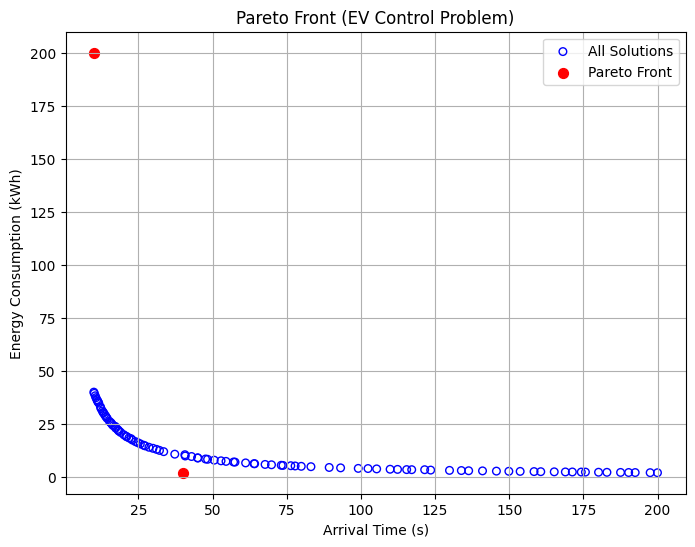

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue', label="All Solutions")
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], s=50, c='red', label="Pareto Front")
plt.title("Pareto Front (EV Control Problem)")
plt.xlabel("Arrival Time (s)")
plt.ylabel("Energy Consumption (kWh)")
plt.legend()
plt.grid(True)
plt.show()